## Setup

In [1]:
from pathlib import Path
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import ast
import numpy as np
from numpy.random import default_rng
from typing import Tuple, Optional, Dict, Any

from src.utils import grid_search_dict

from src.data.ate.exponential_pv import calc_haw, gen_haw, ha_effect

from fct import run_exp, pmmr_exp, kpv_exp, NMMR_exp, save_data

C:\Users\Benedikt\anaconda3new\envs\kompa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
experiment_name = "exponential"
n_sample = 1000
beta_0 = 1 # just shifts
beta_a = 1.2 # the higher the better
beta_w = 0 # set to zero
delta_0 = 1.2
delta = 1.3 # the higher the better
gamma = 0.7 # the higher the better
lam_z = 1.1 # the higher the better
lam_u = 1 # the lower the better
U_noise = np.sqrt(0.1)
A_noise = np.sqrt(0.1)
W_noise = np.sqrt(0.1)
Z_noise = np.sqrt(0.1)
a_start = -2
a_end = 2

data_dic = {
      "name" : experiment_name,
      "n_sample" : n_sample,
      "beta_0": beta_0,
      "beta_a": beta_a,
      "beta_w": beta_w,
      "delta_0": delta_0,
      "delta": delta,
      "gamma": gamma,
      "lam_z": lam_z, 
      "lam_u": lam_u, 
      "U_noise": U_noise,
      "A_noise": A_noise,
      "Z_noise": Z_noise,
      "W_noise": W_noise,
      "a_start": a_start,
      "a_end": a_end,
}


pmmr_configs = {
        "name": "pmmr",
        "lam1": np.logspace(np.log10(1/(450)**2), np.log10(0.25), 50),
        "lam2": 0.01,
        "scale": 0.5,
        "data_scaling": True
}

kpv_configs = {
        "name": "kpv",
        "lam1_max": 0.01,
        "lam1_min":  0.0001,
        "n_lam1_search": 25,
        "lam2_max": 0.01,
        "lam2_min": 0.0001,
        "n_lam2_search": 25,
        "split_ratio": 0.5,
        "scale": 0.5,
        "data_scaling": True,
}

nmmr_u_configs = {
    "name": "nmmr",
    "n_epochs": [2000],
    "batch_size": 100,
    "log_metrics": "True",
    "learning_rate": [0.003],
    "l2_penalty": [3e-06],
    "loss_name": "U_statistic",
    "network_depth": [4],
    "network_width": [80]
}

nmmr_v_configs = {
    "name": "nmmr",
    "n_epochs": [2000],
    "batch_size": 100,
    "log_metrics": "True",
    "learning_rate": [0.003],
    "l2_penalty": [3e-06],
    "loss_name": "V_statistic",
    "network_depth": [3],
    "network_width": [80]
}

## Evaluations

#### Grid search is unfair for KPV!

In [3]:
%%time
sd_list = [5949, 7422, 4388, 2807, 5654, 5518, 1816, 1102, 9886, 1656, 
           4379, 2029, 8455, 4987, 4259, 2533, 9783, 7987, 1009, 2297]

sd_list = [5949, 7422, 4388, 2807, 5654, 5518, 1816, 1102, 9886, 1656]

# save results
results_pmmr = run_exp(model_config = pmmr_configs, data_config=data_dic, sd_list=sd_list)
print("PMMR finished")

Finished with sd: 5949
Finished with sd: 7422
Finished with sd: 4388
Finished with sd: 2807
Finished with sd: 5654
Finished with sd: 5518
Finished with sd: 1816
Finished with sd: 1102
Finished with sd: 9886
Finished with sd: 1656
PMMR finished
CPU times: total: 34min 42s
Wall time: 7min 51s


In [4]:
%%time
results_kpv = run_exp(model_config = kpv_configs, data_config=data_dic, sd_list=sd_list)
print("KPV finished")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Finished with sd: 5949
Finished with sd: 7422
Finished with sd: 4388
Finished with sd: 2807
Finished with sd: 5654
Finished with sd: 5518
Finished with sd: 1816
Finished with sd: 1102
Finished with sd: 9886
Finished with sd: 1656
KPV finished
CPU times: total: 39min 10s
Wall time: 5min 31s


In [5]:
%%time
results_nmmr_u = run_exp(model_config = nmmr_u_configs, data_config=data_dic, sd_list=sd_list)
print("NMMR-U finished")

100%|██████████| 2000/2000 [03:03<00:00, 10.92it/s]


NMMR-U finished
CPU times: total: 1h 56min 4s
Wall time: 29min 14s


In [6]:
%%time
results_nmmr_v = run_exp(model_config = nmmr_v_configs, data_config=data_dic, sd_list=sd_list)
print("NMMR-V finished")
df_save = pd.DataFrame(columns=['model', 'pred_avg', 'train_data', 'test_data', 'pred_all', 
                                'mse_avg', 'mae_avg', 'mse_all', 'mae_all', 'param_opt', 'error', 
                                'std', 'error_abs', 'std_abs', 'model_config', 'data_config'])
df_save = df_save.append([results_pmmr, results_kpv, results_nmmr_u, results_nmmr_v])
save_data(df_save, data_dic)

100%|██████████| 2000/2000 [02:39<00:00, 12.52it/s]


NMMR-V finished
CPU times: total: 1h 47min 5s
Wall time: 26min 51s


In [18]:
# df_save

In [7]:
haw, ha = ha_effect(a_start, a_end, beta_0, beta_a, beta_w, delta_0, delta, U_noise, W_noise)

### Plot

#### Get Data

In [8]:
# results_pmmr = df_save[df_save["model"] == "pmmr"].to_dict(orient='records')[0]
# results_kpv = df_save[df_save["model"] == "kpv"].to_dict(orient='records')[0]
# results_nmmr_u = df_save[df_save["model"] == "nmmr_U_statistic"].to_dict(orient='records')[0]
# results_nmmr_v = df_save[df_save["model"] == "nmmr_V_statistic"].to_dict(orient='records')[0]

A_train = np.squeeze(results_pmmr["train_data"].treatment)
Y_train = np.squeeze(results_pmmr["train_data"].outcome)
A_test = np.squeeze(results_pmmr["test_data"].treatment)
Y_test = np.squeeze(results_pmmr["test_data"].structural)

Y_pred_pmmr = results_pmmr["pred_avg"]
Y_pred_kpv = results_kpv["pred_avg"]
Y_pred_nmmr_u = results_nmmr_u["pred_avg"]
Y_pred_nmmr_v = results_nmmr_v["pred_avg"]

std_pmmr = np.squeeze(results_pmmr["std"])
std_kpv = np.squeeze(results_kpv["std"])
std_nmmr_u = np.squeeze(results_nmmr_u["std"])
std_nmmr_v = np.squeeze(results_nmmr_v["std"])

std_pmmr_abs = np.squeeze(results_pmmr["std_abs"])
std_kpv_abs = np.squeeze(results_kpv["std_abs"])
std_nmmr_u_abs = np.squeeze(results_nmmr_u["std_abs"])
std_nmmr_v_abs = np.squeeze(results_nmmr_v["std_abs"])

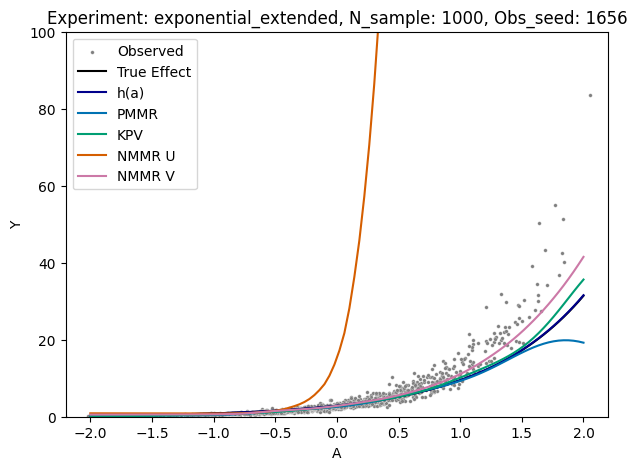

In [9]:
import importlib
importlib.reload(plt)


plt.style.use('seaborn-colorblind')
plt.figure(figsize=(7, 5))
# Obs & True values
sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7)
plt.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
plt.plot(A_test, ha, color='darkblue', label="h(a)", linestyle="solid")

# Predictions
plt.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
plt.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
plt.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
plt.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

plt.title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
plt.xlabel('A')
plt.xlim([-2.2, 2.2])
plt.ylabel('Y')
plt.ylim([0, 100])
plt.legend()
plt.savefig(f"plots/plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}", dpi = 300, format="pdf")
plt.show()

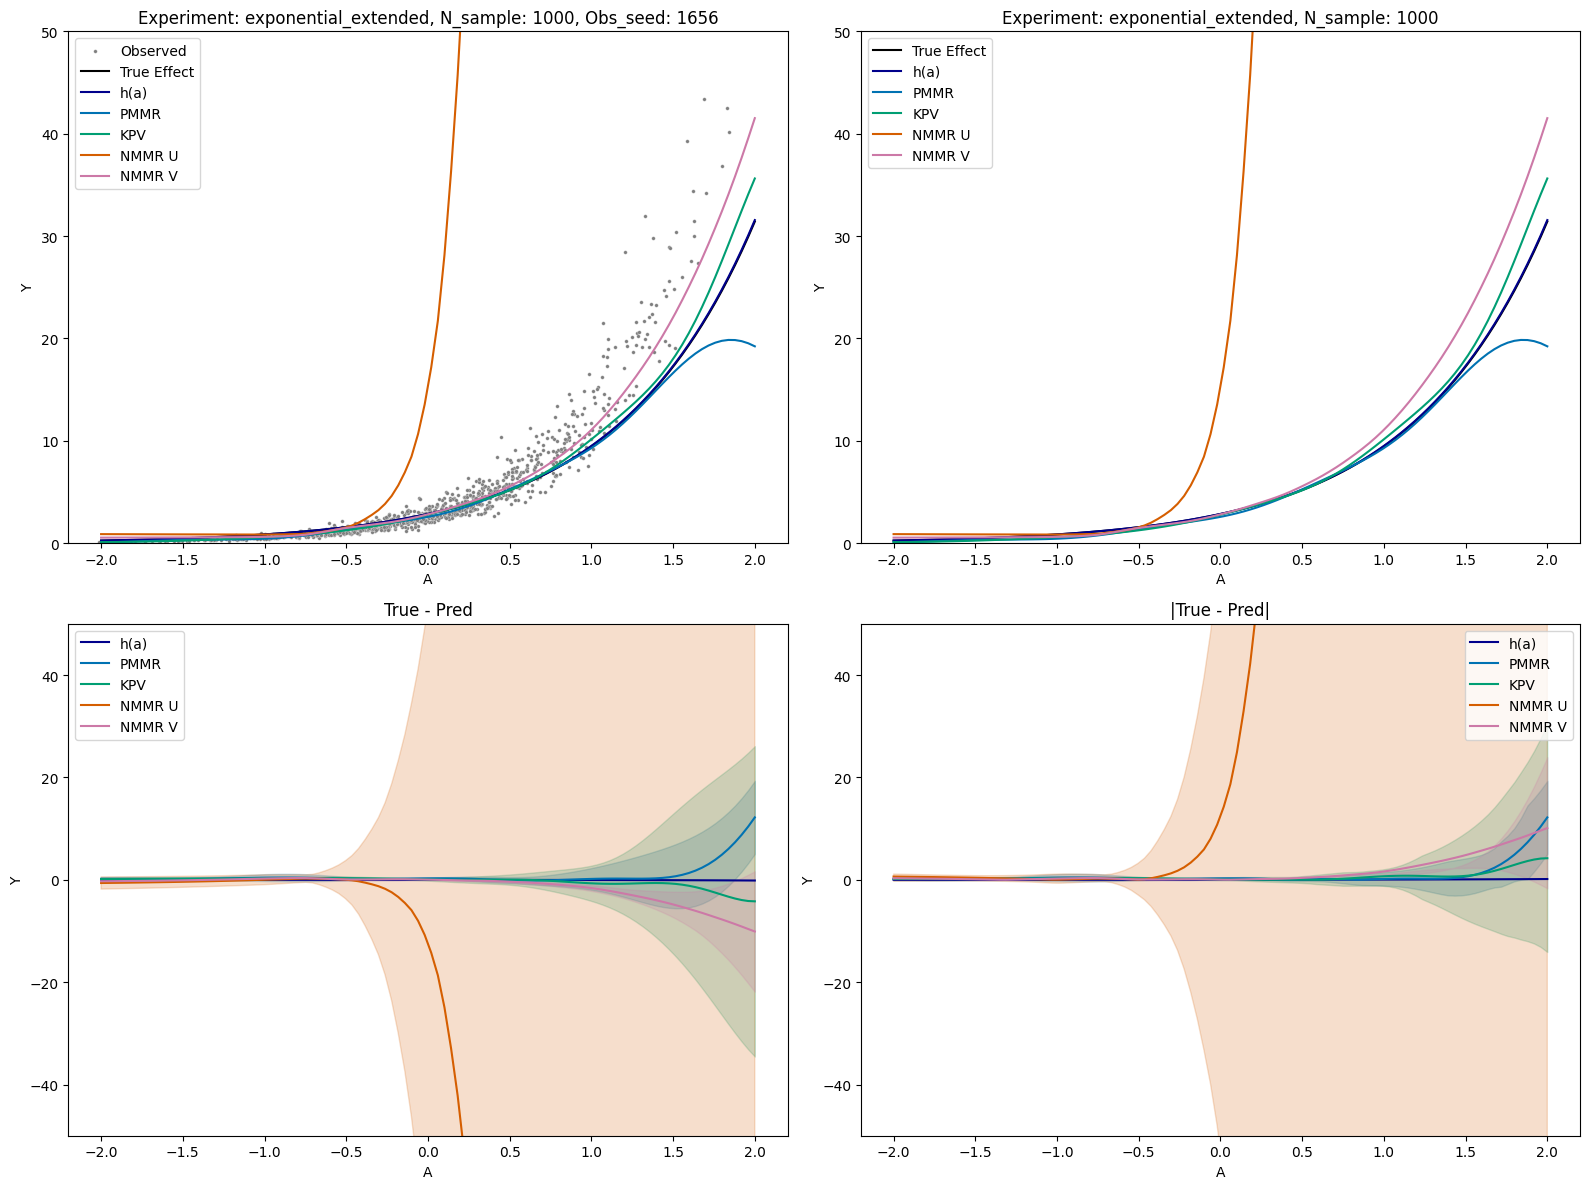

In [10]:
import importlib
importlib.reload(plt)

plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(2, 2, 1)
sns.scatterplot(x=A_train, y=Y_train, color='gray', label='Observed', s=7, ax=ax1)
ax1.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
ax1.plot(A_test, ha, color='darkblue', label="h(a)", linestyle="solid")
ax1.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
ax1.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
ax1.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
ax1.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

ax1.set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}, Obs_seed: {sd_list[-1]}')
ax1.set_xlabel('A')
ax1.set_xlim([-2.2, 2.2])
ax1.set_ylabel('Y')
ax1.set_ylim([0, 50])
ax1.legend()

####

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(A_test, Y_test, color='black', label="True Effect", linestyle="solid")
ax2.plot(A_test, ha, color='darkblue', label="h(a)", linestyle="solid")
ax2.plot(A_test, Y_pred_pmmr,  label="PMMR", linestyle="solid")
ax2.plot(A_test, Y_pred_kpv,  label="KPV", linestyle="solid")
ax2.plot(A_test, Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
ax2.plot(A_test, Y_pred_nmmr_v, label="NMMR V", linestyle="solid")

ax2.set_title(f'Experiment: {experiment_name}, N_sample: {n_sample}')
ax2.set_xlabel('A')
ax2.set_xlim([-2.2, 2.2])
ax2.set_ylabel('Y')
ax2.set_ylim([0, 50])
ax2.legend()

### True vs Pred
alpha = 0.2
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(A_test, Y_test - ha, color='darkblue', label="h(a)", linestyle="solid")
line, = ax3.plot(A_test, Y_test - Y_pred_pmmr,  label="PMMR", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_pmmr - 2*std_pmmr, Y_test - Y_pred_pmmr + 2*std_pmmr, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_kpv,  label="KPV", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_kpv - 2*std_kpv, Y_test - Y_pred_kpv + 2*std_kpv, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_nmmr_u, label="NMMR U", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_nmmr_u - 2*std_nmmr_u, Y_test - Y_pred_nmmr_u + 2*std_nmmr_u, alpha=alpha, color=color)

line, = ax3.plot(A_test, Y_test - Y_pred_nmmr_v, label="NMMR V", linestyle="solid")
color = line.get_color()
ax3.fill_between(A_test, Y_test - Y_pred_nmmr_v - 2*std_nmmr_v, Y_test - Y_pred_nmmr_v + 2*std_nmmr_v, alpha=alpha, color=color)

ax3.set_title('True - Pred')
ax3.set_xlabel('A')
ax3.set_xlim([-2.2, 2.2])
ax3.set_ylabel('Y')
ax3.set_ylim([-50, 50])
ax3.legend(loc = 'upper left')

#### | True - Pred|
alpha = 0.2
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(A_test, np.abs(Y_test - ha), color='darkblue', label="h(a)", linestyle="solid")

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_pmmr),  label="PMMR", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_pmmr) - 2*std_pmmr_abs, np.abs(Y_test - Y_pred_pmmr) + 2*std_pmmr_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_kpv),  label="KPV", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_kpv) - 2*std_kpv_abs, np.abs(Y_test - Y_pred_pmmr) + 2*std_kpv_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_nmmr_u), label="NMMR U", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_nmmr_u) - 2*std_nmmr_u_abs, np.abs(Y_test - Y_pred_pmmr) + 2*std_nmmr_u_abs, alpha=alpha, color=color)

line, = ax4.plot(A_test, np.abs(Y_test - Y_pred_nmmr_v), label="NMMR V", linestyle="solid")
color = line.get_color()
ax4.fill_between(A_test, np.abs(Y_test - Y_pred_nmmr_v) - 2*std_nmmr_v_abs, np.abs(Y_test - Y_pred_pmmr) + 2*std_nmmr_v_abs, alpha=alpha, color=color)

ax4.set_title('|True - Pred|')
ax4.set_xlabel('A')
ax4.set_xlim([-2.2, 2.2])
ax4.set_ylabel('Y')
ax4.set_ylim([-50, 50])
ax4.legend()


###########
plt.tight_layout()
time_stamp = datetime.datetime.now()
time_string = time_stamp.strftime("%Y_%m_%d_%H_%M_%S")
plt.savefig(f"plots/all_plot_experiment_{experiment_name}_n_sample_{n_sample}_obs_seed_{sd_list[-1]}_n_seed_{len(sd_list)}_time_{time_string}", dpi = 300, format="pdf")
plt.show()


In [19]:
import numpy as np
from numpy.random import default_rng

def psi(t: np.ndarray) -> np.ndarray:
    return 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)

rng = default_rng(seed=42)
demand = rng.uniform(0, 10, 1000000)
np.mean(psi(demand))

-2.405634192944296